# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [4]:
df = pd.read_csv('bikes_rent.csv')

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

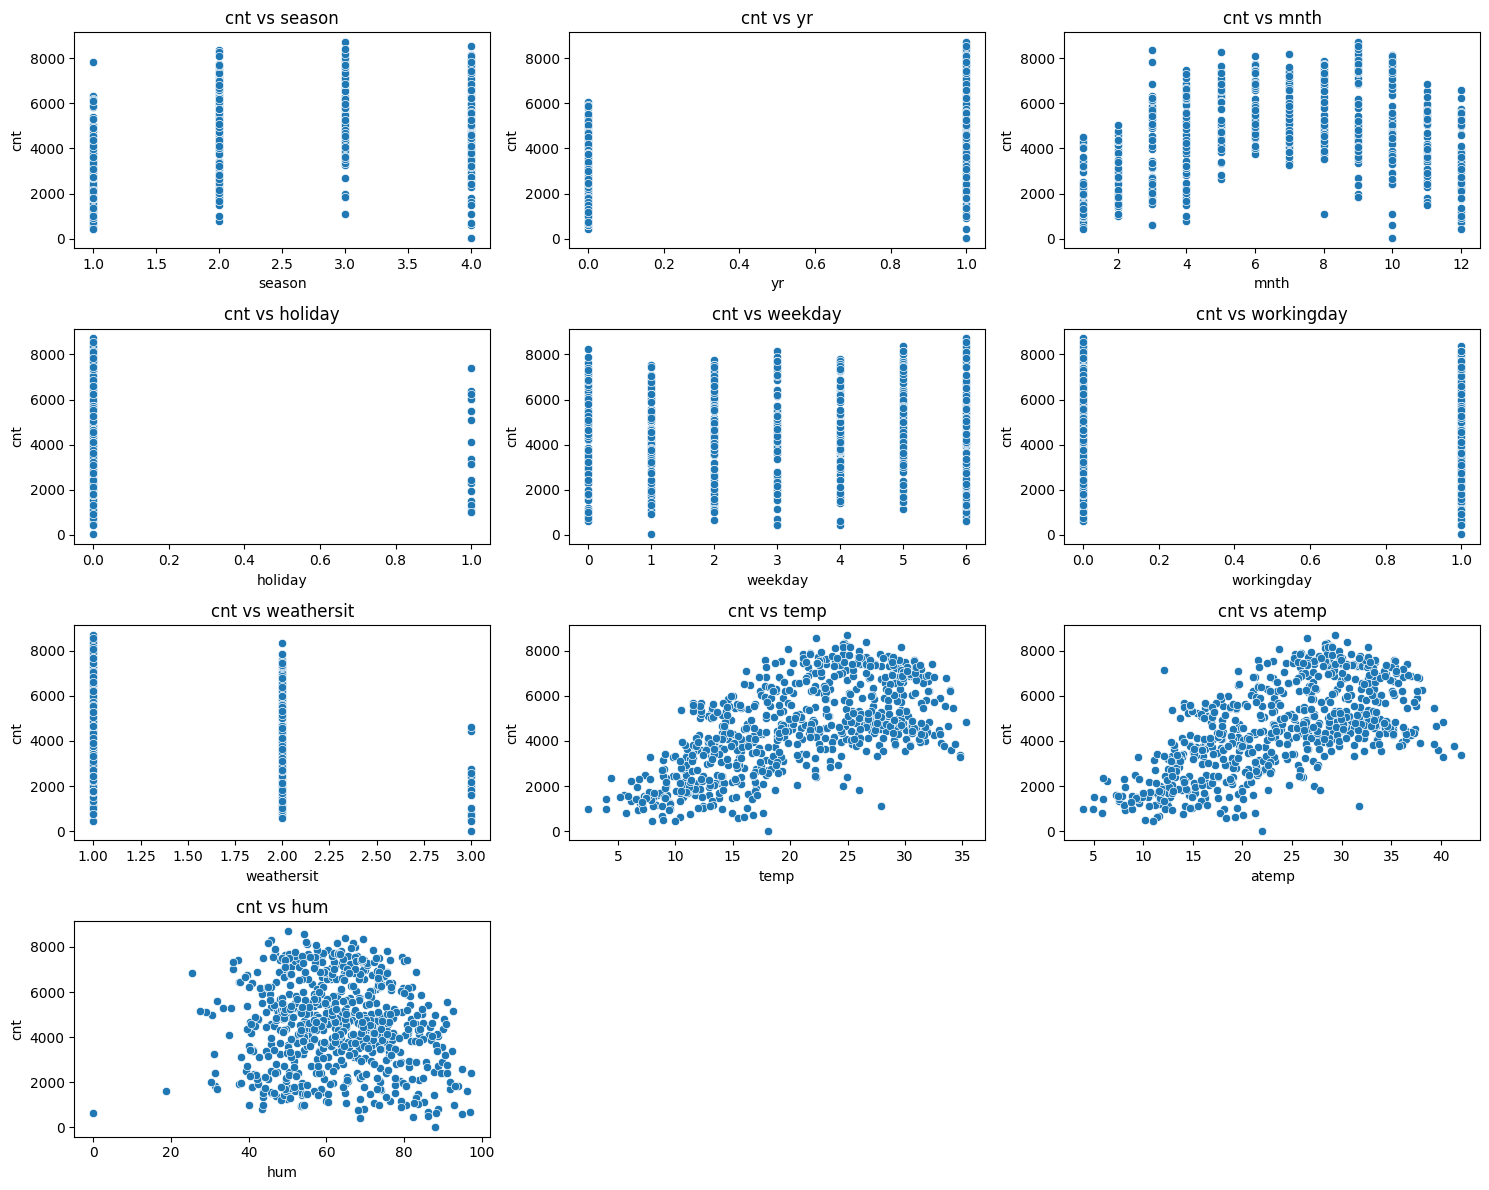

In [5]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
              'temp', 'atemp', 'hum']  

plt.figure(figsize=(15, 12))

for i, attribute in enumerate(attributes, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df[attribute], y=df['cnt'])
    plt.title(f'cnt vs {attribute}')

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

Корреляции с 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


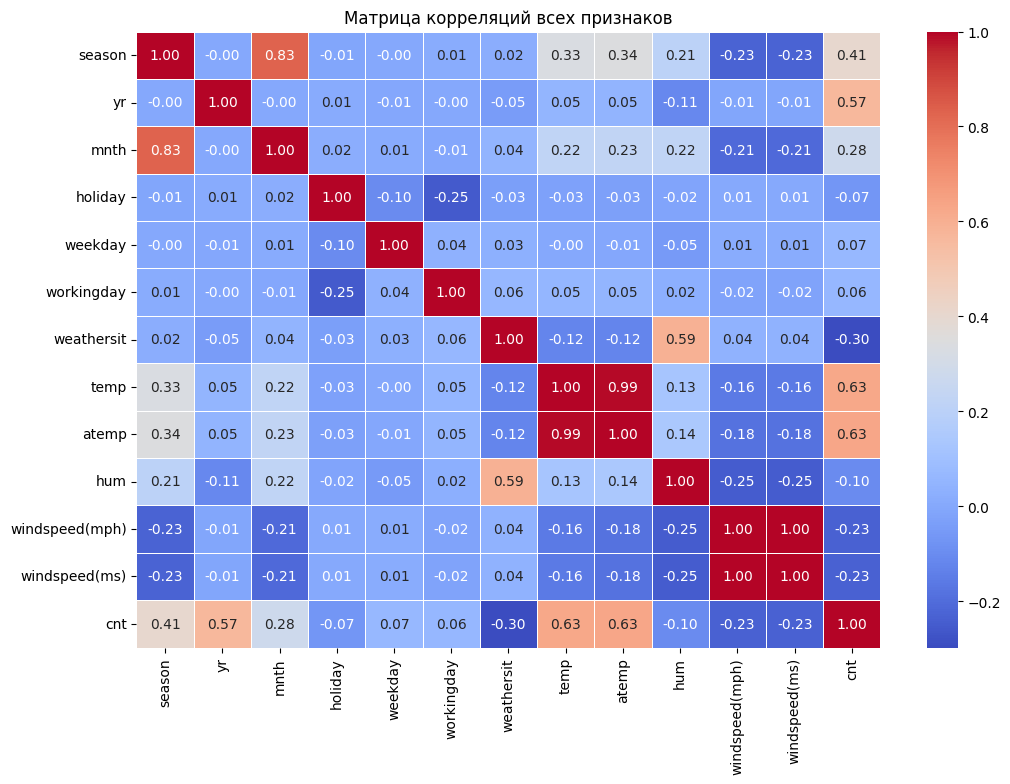

In [6]:
correlations_with_cnt = df.corrwith(df['cnt'])

print("Корреляции с 'cnt':")
print(correlations_with_cnt)

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций всех признаков')
plt.show()

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [7]:
columns_of_interest = ['temp', 'atemp', 'hum', 'cnt']

correlation_matrix = df[columns_of_interest].corr()

print("Корреляционная матрица:")
print(correlation_matrix)

mean_values = df[columns_of_interest].mean()

print("\nСредние значения признаков:")
print(mean_values)

Корреляционная матрица:
           temp     atemp       hum       cnt
temp   1.000000  0.991702  0.126963  0.627494
atemp  0.991702  1.000000  0.139988  0.631066
hum    0.126963  0.139988  1.000000 -0.100659
cnt    0.627494  0.631066 -0.100659  1.000000

Средние значения признаков:
temp       20.310776
atemp      23.717699
hum        62.789406
cnt      4504.348837
dtype: float64


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

print("Середні значення ознак до нормалізації:")
print(df.mean())

Середні значення ознак до нормалізації:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [9]:
df_shuffled = shuffle(df, random_state=42)

X = scale(df_shuffled[df_shuffled.columns[:-1]])  
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
model = LinearRegression()
model.fit(X, y)

print("Ваги ознак (коефіцієнти моделі):")
print(model.coef_)

Ваги ознак (коефіцієнти моделі):
[ 5.70863642e+02  1.02196042e+03 -1.41300633e+02 -8.67576047e+01
  1.37227258e+02  5.63898036e+01 -3.30227183e+02  3.67479903e+02
  5.85552180e+02 -1.45615523e+02  1.24543563e+13 -1.24543563e+13]


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X, y)

weights = linear_model.coef_

feature_names = df.columns[:-1]  
weight_pairs = zip(feature_names, weights)

print("Feature weights (Linear Regression):")
for feature, weight in weight_pairs:
    print(f"{feature}: {weight:.3f}")


Feature weights (Linear Regression):
season: 570.864
yr: 1021.960
mnth: -141.301
holiday: -86.758
weekday: 137.227
workingday: 56.390
weathersit: -330.227
temp: 367.480
atemp: 585.552
hum: -145.616
windspeed(mph): 12454356291009.727
windspeed(ms): -12454356291208.188


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [12]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso()
lasso_model.fit(X, y)

print("Коэффициенты для Lasso-регрессии (L1-регуляризация):")
for feature, coef in zip(df.columns[:-1], lasso_model.coef_):
    print(f"{feature}: {coef:.3f}")



Коэффициенты для Lasso-регрессии (L1-регуляризация):
season: 560.242
yr: 1019.463
mnth: -128.731
holiday: -86.153
weekday: 137.348
workingday: 55.212
weathersit: -332.370
temp: 376.363
atemp: 576.531
hum: -144.129
windspeed(mph): -197.140
windspeed(ms): -0.000


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [13]:
ridge = Ridge()
ridge.fit(X, y)

print("\nКоэффициенты для Ridge-регрессии (L2-регуляризация):")
for feature, coef in zip(df_shuffled.columns[:-1], ridge.coef_):
    print(f"{feature}: {coef}")


Коэффициенты для Ridge-регрессии (L2-регуляризация):
season: 563.0645722520164
yr: 1018.9483787875275
mnth: -131.87332028247582
holiday: -86.74609799709243
weekday: 138.00511117871926
workingday: 55.90311037506429
weathersit: -332.34978849907236
temp: 386.45788919189926
atemp: 566.3470470600766
hum: -145.0713272986732
windspeed(mph): -99.25944108174306
windspeed(ms): -99.25944115438946


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 50)  

coefs_lasso = []  
coefs_ridge = [] 

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)  

    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_) 

coefs_lasso = pd.DataFrame(coefs_lasso, columns=df.columns[:-1], index=alphas)
coefs_ridge = pd.DataFrame(coefs_ridge, columns=df.columns[:-1], index=alphas)


Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

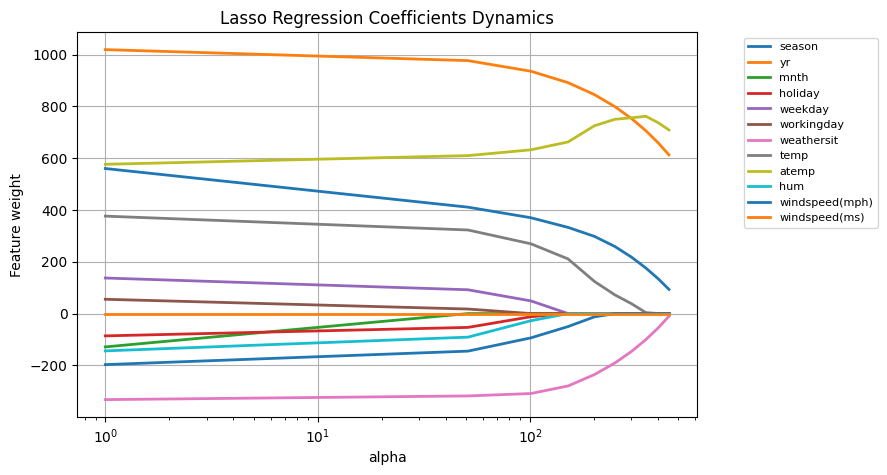

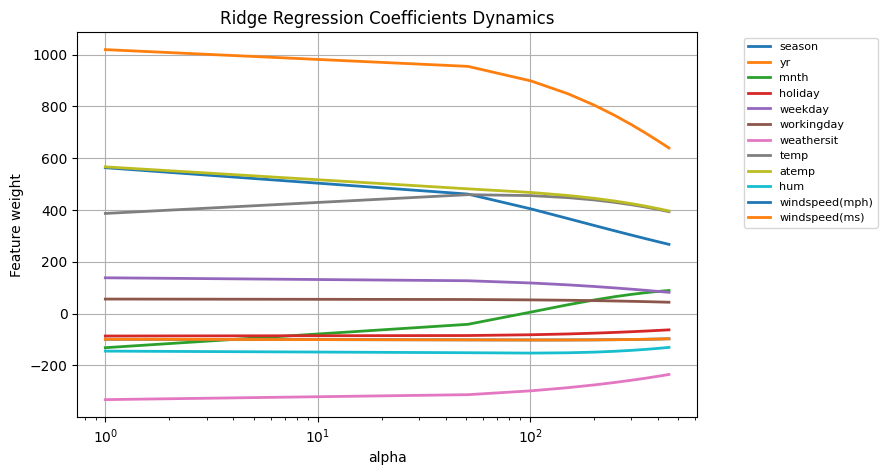

In [15]:
plt.figure(figsize=(8, 5))
for feature in coefs_lasso.columns:
    plt.plot(alphas, coefs_lasso[feature], label=feature, linewidth=2)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=8)
plt.xlabel("alpha")
plt.ylabel("Feature weight")
plt.title("Lasso Regression Coefficients Dynamics")
plt.xscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
for feature in coefs_ridge.columns:
    plt.plot(alphas, coefs_ridge[feature], label=feature, linewidth=2)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=8)
plt.xlabel("alpha")
plt.ylabel("Feature weight")
plt.title("Ridge Regression Coefficients Dynamics")
plt.xscale('log')
plt.grid()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

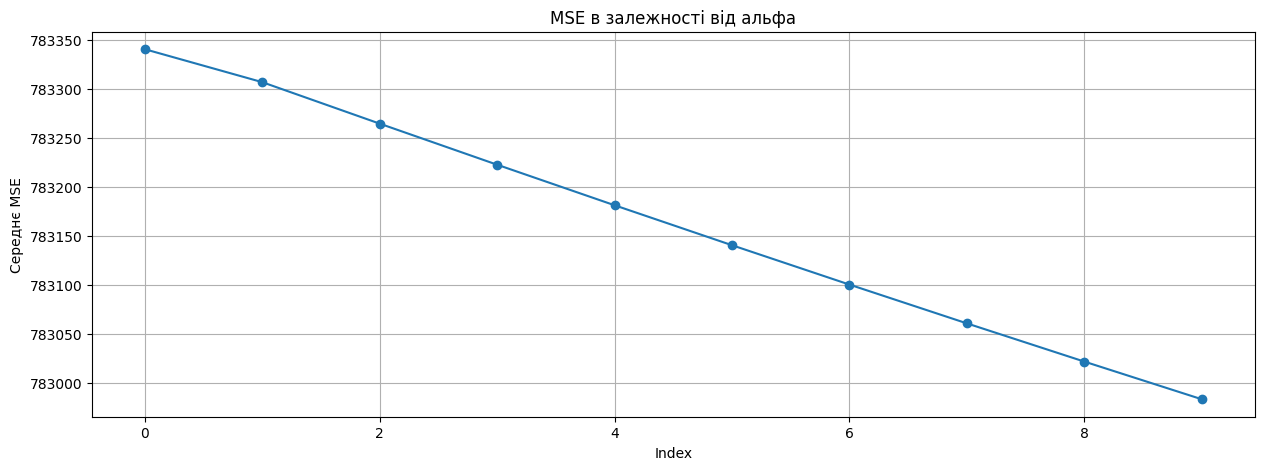

Оптимальне значення альфа: 5.5
Ознаки та їхні коефіцієнти:
season: 534.8412277423047
yr: 1015.5005601809249
mnth: -102.90862543017649
holiday: -83.57979169374825
weekday: 132.98887720834452
workingday: 51.92263357473295
weathersit: -330.74079958420623
temp: 371.2381738420745
atemp: 580.9203209774586
hum: -140.41967929745982
windspeed(mph): -192.30801156181187
windspeed(ms): -2.6986568470996078e-08


In [16]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

alphas = np.arange(5.5, 6.5, 0.1)

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

mse_path_mean = np.mean(lasso_cv.mse_path_, axis=1)

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)
    
    x = np.arange(len(data))  
    plt.plot(x, data, 'o-')  
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

create_plot(mse_path_mean, title="MSE в залежності від альфа", xlabel="Index", ylabel="Середнє MSE")

print("Оптимальне значення альфа:", lasso_cv.alpha_)
print("Ознаки та їхні коефіцієнти:")
for feature, coef in zip(df_shuffled.columns[:-1], lasso_cv.coef_):
    print(f"{feature}: {coef}")




In [17]:
alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5)

regressor.fit(X, y)

print("Оптимальне значення альфа:", regressor.alpha_)
print("Коефіцієнти:", regressor.coef_)

Оптимальне значення альфа: 1
Коефіцієнти: [ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
  1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
  5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 5.5, MSE = 693981.6133818653
Alpha = 6.399999999999997, MSE = 883478.9021758946
Alpha = 5.5, MSE = 718145.0452883026
Alpha = 6.399999999999997, MSE = 865919.0676463932
Alpha = 6.399999999999997, MSE = 752718.1381592425


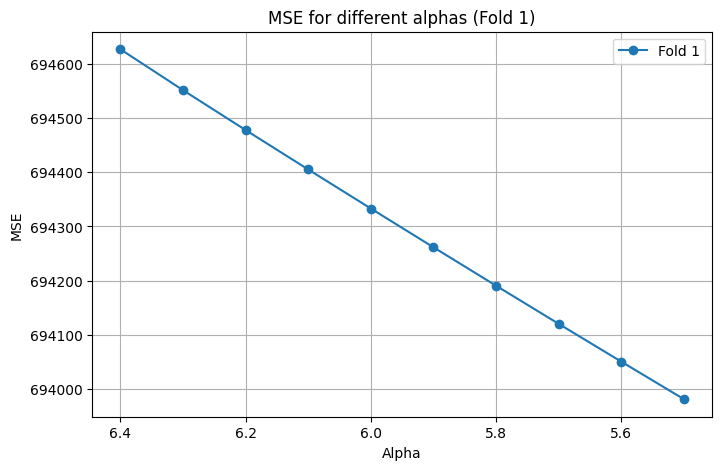

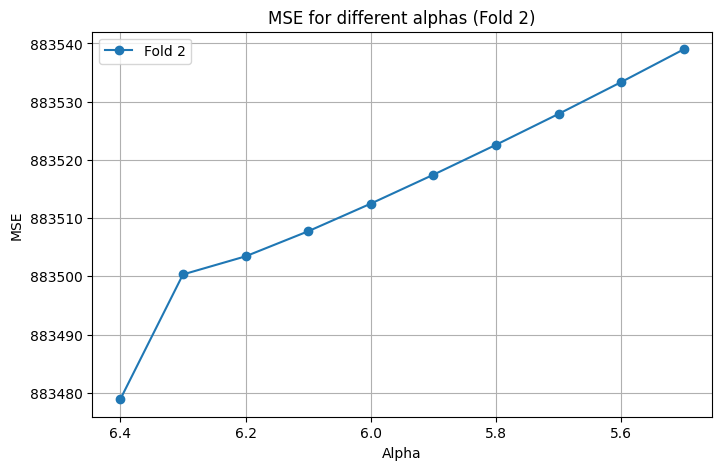

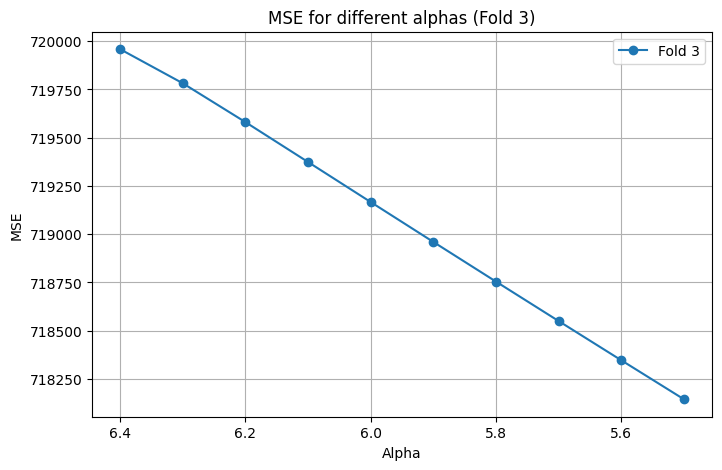

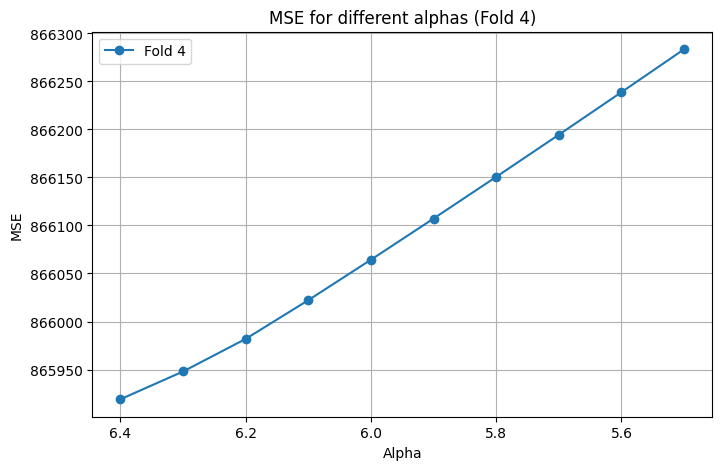

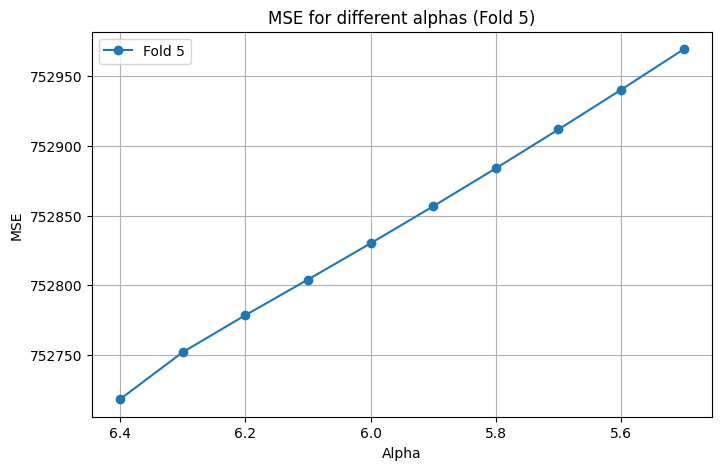

In [18]:
min_mse_per_fold = np.min(lasso_cv.mse_path_, axis=0)
optimal_alpha_per_fold = [lasso_cv.alphas_[np.argmin(mse)] for mse in lasso_cv.mse_path_.T]

print("Alphas with minimum MSE:")
for i, (alpha, mse) in enumerate(zip(optimal_alpha_per_fold, min_mse_per_fold)):
    print(f"Alpha = {alpha}, MSE = {mse}")

for fold in range(lasso_cv.mse_path_.shape[1]):
    plt.figure(figsize=(8, 5))
    plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, fold], marker='o', label=f'Fold {fold + 1}')
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title(f"MSE for different alphas (Fold {fold + 1})")
    plt.gca().invert_xaxis() 
    plt.legend()
    plt.grid(True)
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [ ]:
Для відповіді на це запитання виберіть значення alpha, за якого модель Lasso або Ridge було остаточно налаштовано. Потім подивіться на рядок із коефіцієнтами ознак для цього значення alpha в таблиці coefs_lasso або coefs_ridge.

Визначте 4 ознаки з найвищими позитивними коефіцієнтами і перерахуйте їх. Припустимо, що такими ознаками можуть бути, наприклад, temp (температура), atemp (температура, що відчувається), season (сезон), і hum (вологість), якщо вони мають позитивний вплив.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [42]:
У тій самій таблиці коефіцієнтів виберіть 3 ознаки з найвищими негативними коефіцієнтами.

Імовірно, такими ознаками можуть бути, наприклад, windspeed (швидкість вітру), rain (дощ) і, можливо, workingday (робочий день), якщо вони чинять негативний вплив на cnt.

На графіках можна побачити, що зі збільшенням швидкості вітру або випаданням опадів кількість оренд падає, що є логічним. Сильний вітер або дощ роблять поїздку на велосипеді менш зручною та безпечною, тому люди менше схильні їх орендувати в таких умовах.

SyntaxError: unterminated string literal (detected at line 1) (4222078913.py, line 1)

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [ ]:
Знайдіть ознаки з коефіцієнтами в діапазоні від -1 до 1. Такі ознаки могли б містити менш значущі чинники, наприклад holiday (вихідний) або інші, що незначно впливають на попит.

Модель могла виключити ці ознаки, тому що вони не мають значущого внеску в передбачення кількості оренд. На графіках можна помітити, що між cnt і цими ознаками немає явної кореляції або залежності.


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.